<a href="https://colab.research.google.com/github/JayBaileyCS/RLAlgorithms/blob/main/DQN_From_Scratch_Procgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym==0.23.0
!pip install procgen==0.10.4

In [ ]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import copy
import time
from psutil import virtual_memory
from procgen import ProcgenEnv

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)

    def forward(self, x):
        inputs = x
        x = nn.functional.relu(x)
        x = self.conv0(x)
        x = nn.functional.relu(x)
        x = self.conv1(x)
        return x + inputs


class ConvSequence(nn.Module):
    def __init__(self, input_shape, out_channels):
        super().__init__()
        self._input_shape = input_shape
        self._out_channels = out_channels
        self.conv = nn.Conv2d(in_channels=self._input_shape[0], out_channels=self._out_channels, kernel_size=3, padding=1)
        self.res_block0 = ResidualBlock(self._out_channels)
        self.res_block1 = ResidualBlock(self._out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        x = self.res_block0(x)
        x = self.res_block1(x)
        assert x.shape[1:] == self.get_output_shape()
        return x

    def get_output_shape(self):
        _c, h, w = self._input_shape
        return (self._out_channels, (h + 1) // 2, (w + 1) // 2)


class DeepQNetwork(nn.Module):
    def __init__(self, env):
        super(DeepQNetwork, self).__init__()
        h, w, c = env.single_observation_space.shape
        shape = (c, h, w)
        conv_seqs = []
        for out_channels in [16, 32, 32]:
            conv_seq = ConvSequence(shape, out_channels)
            shape = conv_seq.get_output_shape()
            conv_seqs.append(conv_seq)
        conv_seqs += [
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(in_features=shape[0] * shape[1] * shape[2], out_features=256),
            nn.ReLU(),
        ]
        self.network = nn.Sequential(*conv_seqs, nn.Linear(256, env.single_action_space.n))

    def forward(self, x):
      return self.network(x.permute((0, 3, 1, 2)) / 255.0)

In [ ]:
# Instantiate the replay buffer
class ReplayBuffer:

  def __init__(self, max_frames):
    self.max_frames = max_frames
    self.buffer = np.zeros_like([0 for i in range(max_frames)], dtype=object)
    self.index = 0

  def add(self, frame):
    frame["index"] = [self.index]
    self.buffer[self.index % self.max_frames] = frame
    self.index = self.index + 1

  def sample(self, num_samples):
    experiences = np.random.choice(self.buffer[0:min(self.index-1, self.max_frames-1)], size=[num_samples], replace=True)
    return {"obs": self.transform(experiences, "obs", np.float32, torch.float32, [num_samples, 64, 64, 3]),
            "next_obs": self.get_next_obs_batch(experiences),
            "actions": self.transform(experiences, "action", np.int32, torch.int64, [num_samples, 1]),
            "rewards": self.transform(experiences, "reward", np.float32, torch.float32, [num_samples, 1]),
            "dones": self.transform(experiences, "done", np.float32, torch.float32, [num_samples, 1])}

  def transform(self, array, key, np_dtype, torch_dtype, shape):
      item = [item[key] for item in array]
      item = np.array(item, dtype=np_dtype)
      item = torch.as_tensor(item, dtype=torch_dtype)
      return item.reshape(shape)

  def get_next_obs_batch(self, experiences):
    indices = [experience["index"][0] if experience["done"][0] > 0 else experience["index"][0] + 1 for experience in experiences]
    next_obs_batch = [self.buffer[index % self.max_frames]["obs"] for index in indices]
    return torch.as_tensor(np.array(next_obs_batch, dtype=np.float32), dtype=torch.float32).reshape(len(indices), 64, 64, 3)

In [ ]:
def make_env(env_id, seed):
      envs = ProcgenEnv(num_envs=1, env_name=env_id, num_levels=0, start_level=0, distribution_mode="easy")
      envs = gym.wrappers.TransformObservation(envs, lambda obs: obs["rgb"])
      envs.single_action_space = envs.action_space
      envs.single_observation_space = envs.observation_space["rgb"]
      envs.is_vector_env = True
      envs = gym.wrappers.RecordEpisodeStatistics(envs)
      envs = gym.wrappers.NormalizeReward(envs)
      envs = gym.wrappers.TransformReward(envs, lambda reward: np.clip(reward, -10, 10))
      return envs

In [ ]:
# Helper functions
def plot_results(steps, rewards, total_timesteps, avg, benchmark):
  plt.plot([item for item in get_rolling_average(steps, avg)], 
          [item for item in get_rolling_average(rewards, avg)])
  max_x = [0, total_timesteps]
  max_y = [benchmark, benchmark] # Cartpole max.
  plt.plot(max_x, max_y, color='r', ls=':')
  plt.xlabel(f"Number of Steps (Avg. {avg})")
  plt.ylabel(f"Current Return (Avg. {avg})")
  plt.show()

def get_rolling_average(items, num):
    rolling = []
    for i in range(len(items)-num):
        rolling.append(sum(items[i:i+num])/num)
    return rolling

def calculate_epsilon(step, epsilon_start, epsilon_finish, 
                      total_timesteps, exploration_fraction):
  finish_step = total_timesteps * exploration_fraction
  if step > finish_step:
    return epsilon_finish
  epsilon_range = epsilon_start - epsilon_finish
  return epsilon_finish + (((finish_step - step) / finish_step) * epsilon_range)

def print_colab_info():
  # Print GPU and RAM info for Colab instance.
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

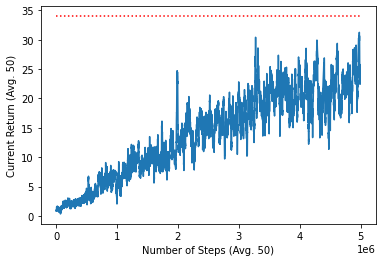

In [ ]:
def train(env, total_timesteps, batch_size, buffer_size, train_frequency, seed,
          target_network_update_frequency,  gamma, learning_rate, epsilon_start, 
          epsilon_finish, exploration_fraction, learn_start_size):
  
  env = make_env(env, seed)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print(device)
  print_colab_info()

  writer = SummaryWriter(f"runs/test")
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True if seed > 0 else False

  # Initialise replay memory D to capacity N
  buffer = ReplayBuffer(buffer_size)

  # Initialize action-value function Q and target network.
  q_network = DeepQNetwork(env).to(device)
  target_network = DeepQNetwork(env).to(device)
  target_network.load_state_dict(q_network.state_dict())
  optimiser = torch.optim.Adam(q_network.parameters(), learning_rate)

  obs = env.reset()
  episode_end_steps = []
  episode_rewards = []
  start_time = time.time()

  for step in range(total_timesteps):

    # Select random action with p(epsilon), else argmax(q).
    epsilon = calculate_epsilon(step, epsilon_start, epsilon_finish, 
                                total_timesteps, exploration_fraction)
    
    if random.random() < epsilon:
      action = env.action_space.sample()
    else:
      logits = q_network(torch.Tensor(obs).to(device))
      action = torch.argmax(logits, dim=1).cpu().numpy()

    next_obs, reward, done, info = env.step(np.array(torch.as_tensor(action).reshape(1,)))
    next_obs_copy = next_obs.copy()

    # Store transition in D. (Note: Can halve memory here by not storing next_obs and instead pointing to obs[index+1] in buffer?)
    buffer.add({"obs": obs, "action": [action], "reward": [reward], "done": [1. if done else 0.]})
    
    if done and "episode" in info[0].keys():
        print(f"global_step={step}, episodic_return={info[0]['episode']['r']}")
        writer.add_scalar("charts/episodic_return", info[0]["episode"]["r"], step)
        writer.add_scalar("charts/episodic_length", info[0]["episode"]["l"], step)
        writer.add_scalar("charts/epsilon", epsilon, step)
        episode_end_steps.append(step)
        episode_rewards.append(info[0]['episode']['r'])
        obs = env.reset()
        continue

    obs = next_obs

    if step > learn_start_size and step % train_frequency == 0:
    
      # Sample replay experiences.
      experiences = buffer.sample(batch_size)
      experiences = {i:j.to(device) for (i, j) in experiences.items()}

      with torch.no_grad(): # We want to sample the Q-network here, but not update it yet.

        target_max, _ = target_network(experiences["next_obs"]).max(dim=1) # The _ removes the indices we don't want, leaving only the values.
        td_target = experiences["rewards"].flatten() + gamma * target_max * (1 - experiences["dones"].flatten())

      # Collect tensor of predicted rewards associated with the actions taken.
      old_val = q_network(experiences["obs"]).gather(1, experiences["actions"]).squeeze()

      # Calculate loss
      loss = F.mse_loss(td_target, old_val)

      # Gradient descent
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      # Logs
      if step % 1000 == 0:
          writer.add_scalar("losses/td_loss", loss, step)
          writer.add_scalar("losses/q_values", old_val.mean().item(), step)
          print("SPS:", int(step / (time.time() - start_time)))
          writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)),step)

    # Update target network.
    if step % target_network_update_frequency == 0:
      target_network.load_state_dict(q_network.state_dict())

  env.close()
  plot_results(episode_end_steps, episode_rewards, total_timesteps, 50, 34)

train(env='starpilot', total_timesteps=5_000_000, batch_size=32, buffer_size=1_000_000, train_frequency=4, seed=1, target_network_update_frequency=1000, gamma=0.99, learning_rate=1e-4, epsilon_start=1, epsilon_finish=0.01, exploration_fraction=0.1, learn_start_size=80000)